__Batch run for zonal stats__ \
Tips from: https://gorelick.medium.com/fast-er-downloads-a2abd512aa26 \
Here, HydroLakes are the vectors, not BAWLD. Dataset is much larger and complicated.
TODOL
* rm original HL attributes before download from EE

## I/O

In [1]:
import os
from pathlib import Path
import multiprocessing
import numpy as np
from scipy.stats import binned_statistic

from retry import retry
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns
import pyogrio


In [20]:
## I/O
modN = 300000
analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v4/'
table_dir = os.path.join(analysis_dir, 'tables')
for dir in [analysis_dir, table_dir]:
    os.makedirs(dir, exist_ok=True)

## Derived
# modstr = 'mod'+str(modN)

In [3]:
## Register with ee using high-valume (and high-latency) endpoint
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # NOT 'https://earthengine.googleapis.com'

## Functions

In [4]:
def getRequests():
    ''' Based on unique lat/long indexes in BAWLD'''

    ## Load shapefile to join
    gdf_bawld = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')

    ## For test run: filter only a few tiles
    # gdf_bawld.query("(Lat > 59) and (Lat < 60) and (Long > -109) and (Long < -102)", inplace=True) # comment out

    return gdf_bawld[['Long', 'Lat']].to_numpy()

## testing
# foo = getRequests()
# for f in foo:
#     print(f)

# foo

In [5]:
@retry(tries=7, delay=1, backoff=3) # (tries=10, delay=1, backoff=2) # 7,1,3 causes max delay of 12 min, hopefully enough to clear "service unavailable errors."
def getResult(index, group):
    """
    Handle the HTTP requests to download one result. index is python index and long is longitude, used for aggregation.
    index is placeholder
    group is an object that represents a unique value within a grouping (e.g. country name, grid cell longitude), and is not related to "group" in function geemap.zonal_statistics_by_group
    """
    ''' TODO: for real, filter to only Arctic X, change scale and tile scale X, change load gdf BB'''
    ## I/O
    out_dir = os.path.join(analysis_dir, 'tiles')
    out_pth = os.path.join(out_dir, f'HL_zStats_Oc_Long{group[0]}_Lat{group[1]}.csv')

    ## Don't overwrite if starting again
    if os.path.exists(out_pth) or os.path.exists(out_pth+'.txt'):
        return

    ## CRS (ist there a smarter way to do this?)
    crs = 'PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["Unknown",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_origin",45.5],PARAMETER["central_meridian",-114.125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
    # crs = 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6931"]]'

    ## Load vect and compute mod of ID variable to use for grouping, filtering to high latitudes
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10") #.filter("Pour_lat > 45.0") #.map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectF = vectF.filter("Pour_lat > 59.55").filter("Pour_lat < 59.56") #.filter("Long == -126.25")
    # vect = vect.filter("Hylak_id < 500").filter("Lake_area < 1000")
    
    ## Load GSW
    gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    occurrence = gsw.select('occurrence').unmask()

    ## Filter based on bawld cell geometry (note: cells are unequal area)
    # vectF = vect.filter(ee.Filter.eq(modstr, group))
    # groupEE = [ee.Number.float(group[0]) , ee.Number.float(group[1])] # list(map(ee.Number.float, group)) # convert to server object
    vectF = vect.filter(ee.Filter.And(ee.Filter.expression(f"(Pour_long > {group[0]-0.25}) && (Pour_long <= {group[0]+0.25})"), 
        ee.Filter.And(ee.Filter.expression(f"(Pour_lat > {group[1]-0.25}) && (Pour_lat <= {group[1]+0.25})"))))
    nFeats = vectF.size().getInfo()
    print(f'Number of features in chunk: {nFeats}')
    # print(vect.size())
    # print(vectF.size())
    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    if nFeats != 0:
        geemap.zonal_statistics_by_group(
            occurrence,
            vectF,
            out_pth,
            statistics_type='SUM',
            denominator=1000000,
            decimal_places=3,
            crs=crs,
            scale=30, # meters, specifiy to compute at native res (default would be 300m)
            tile_scale=2 # default is 1, increase number to reduce chunking tile size (it won't affect results, but will take longer and use less mem)
        )
        print("Done with group: ", group)
    else:
        print('No features within region filtered by group.')
        Path(out_pth + '.txt').touch()

## Apply functions via GEE calls in parallel

In [6]:
## Testing
# vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)
# print(vect.filter("Hylak_id < 500").filter("Lake_area < 1000").size().getInfo())
# print('Number of features in chunk: ', vect.filter("Hylak_id < 1000").size())
# vect.first().get('mod50')
# vect.propertyNames()
# vect.first().propertyNames() # to actually print the result!
# vect.get('mod50')

In [7]:
## Test on single (Error: property 'element' is required means some filter returned zero. )
# getResult(3, 1)
# getResult(0, np.array([-104.25, 51.25]))

In [8]:
## View expected number of results
items = getRequests()
# print(f'Number of items: {len(items)}')

In [9]:
print(f'Number of items: {len(items)}')

Number of items: 23469


In [10]:
## Run function
# items = getRequests() # a list whose length is the number of groups to use for parallelizing # np.arange(modN) #
print(f'Sending request in {len(items)} chunks...')
pool = multiprocessing.Pool(30) # 25
pool.starmap(getResult, enumerate(items))
pool.close()
pool.join()

Sending request in 23469 chunks...
Number of features in chunk: 1
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 89
Number of features in chunk: 13
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 34
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 1
Number of features in chunk: 364
Number of features in chunk: 35
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Number of features in chunk: 372
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... Computing (Hi Ethan!)... 

Number of features in chunk: 109
Number of features in chunk: 2
Generating URL ...
Number of features in chunk: 1
Number of features in chunk: 2
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Generating URL ...
Generating URL ...
Number of fe

## Load and piece together

In [2]:
# Load files using dask
# from https://mungingdata.com/pandas/read-multiple-csv-pandas-dataframe/
tile_dir = os.path.join(analysis_dir, 'tiles')
ddf = dd.read_csv(f"{tile_dir}/*.csv", assume_missing=True, on_bad_lines='skip', dtype={'system:index': 'object', 'Lake_name': 'object'}) # latter argument suggested by dask error and it fixes it!

NameError: name 'os' is not defined

In [4]:
## convert to pandas df
df = ddf.compute()
df = df.drop_duplicates(subset='Hylak_id').reset_index().drop('index', axis=1)
df

Class_70  Class_71  Class_72  Class_73  Class_74  Class_75  Class_76  \
0           0.001     0.002     0.000     0.001     0.001     0.000     0.003   
1           0.000     0.000     0.000     0.000     0.000     0.001     0.001   
2           0.003     0.000     0.000     0.001     0.001     0.001     0.000   
3           0.000     0.000     0.000     0.000     0.001     0.001     0.000   
4           0.001     0.000     0.001     0.001     0.000     0.000     0.003   
...           ...       ...       ...       ...       ...       ...       ...   
1112147       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112148       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112149       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112150       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112151       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         Class_77  Class_sum  Class_8  ...  Vol_res   Dis_avg   Pour_lat  \
0           0.001      0.248    0.000  ...      0.0     0.131  50.391481   
1           0.005      0.253    0.005  ...      0.0     3.071  50.121770   
2           0.003      0.363    0.001  ...      0.0     0.005  50.490288   
3           0.002      0.109    0.001  ...      0.0     0.001  50.485042   
4           0.003      0.154    0.000  ...      0.0     0.001  50.357718   
...           ...        ...      ...  ...      ...       ...        ...   
1112147       NaN      0.374      NaN  ...      0.0     0.000  79.639685   
1112148       NaN      0.480      NaN  ...      0.0 -9999.000  79.627083   
1112149       NaN      2.236      NaN  ...      0.0     0.695  79.532163   
1112150       NaN      0.683      NaN  ...      0.0     2.251  79.580108   
1112151       NaN      2.120      NaN  ...      0.0     0.002  79.663504   

         Vol_src  Country  Lake_name          system:index  Class_98  \
0            3.0   Canada        NaN  001b0000000000004e0d       NaN   
1            3.0   Canada        NaN  001b00000000000051b5       NaN   
2            3.0   Canada        NaN  001b0000000000004c9d       NaN   
3            3.0   Canada        NaN  001b0000000000004cb5       NaN   
4            3.0   Canada        NaN  001b0000000000004e80       NaN   
...          ...      ...        ...                   ...       ...   
1112147      3.0   Russia        NaN  001f0000000000008301       NaN   
1112148      3.0   Russia        NaN  001f0000000000008305       NaN   
1112149      3.0   Russia        NaN  001f00000000000079b8       NaN   
1112150      3.0   Russia        NaN  001f000000000000830d       NaN   
1112151      3.0   Russia        NaN  001f00000000000079b6       NaN   

         Class_99  Class_100  
0             NaN        NaN  
1             NaN        NaN  
2             NaN        NaN  
3             NaN        NaN  
4             NaN        NaN  
...           ...        ...  
1112147       NaN        NaN  
1112148       NaN        NaN  
1112149       NaN        NaN  
1112150       NaN        NaN  
1112151       NaN        NaN  

[1112152 rows x 124 columns]

In [15]:
## Debugging LSD.py
np.any(df.Lake_area ==0)

False

In [11]:
## ensure df has unique Hylak_id keys
df = df.drop_duplicates(subset='Hylak_id')

## ensure df has unique Hylak_id keys
assert len(df) - len(df.drop_duplicates(subset='Hylak_id')) == 0

In [6]:
## Save as excel as intermediate step
df_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.csv.gz')
df.to_csv(df_pth, compression='gzip')

In [4]:
## START HERE if not running GEE part
## Load df
df_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.csv.gz')
df = pd.read_csv(df_pth)

/tmp/ipykernel_11555/1826560867.py:4: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_pth)


## Bin GSW in 4 bins

In [5]:
## Mask in occurence columns and change values to int
oc_columns = list(map(lambda c: ('Class_' in c) and ('sum' not in c), df.columns)) # occurrence columns positive mask. use map function, rather than for loop, for practice!
oc_column_vals = list(map(lambda c: int(c.replace('Class_', '')), df.columns[oc_columns])) # all relevant occurance fields converted to ints, as a list
# oc_column_vals

In [6]:
bStat = binned_statistic(oc_column_vals, values=df.iloc[:, oc_columns], statistic=np.nansum, bins=[0, 5, 50, 95, 100]) # 
bStat

BinnedStatisticResult(statistic=array([[2.000e-03, 1.300e-02, 2.330e-01, 0.000e+00],
       [1.870e-01, 3.500e-02, 3.100e-02, 0.000e+00],
       [1.700e-02, 2.600e-02, 3.200e-01, 0.000e+00],
       ...,
       [2.236e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [6.830e-01, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.120e+00, 0.000e+00, 0.000e+00, 0.000e+00]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4]))

In [7]:
bin_labels = ['0-5', '5-50', '50-95', '95-100']
dfB = pd.DataFrame(bStat.statistic, columns=bin_labels) / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 #, index=df.index) # df binned
dfB['Hylak_id'] = df.Hylak_id
dfB['Class_sum'] = df.Class_sum
dfB 

0-5       5-50      50-95  95-100   Hylak_id  Class_sum
0          0.806452   5.241935  93.951613     0.0   955819.0      0.248
1         73.913043  13.833992  12.252964     0.0   961301.0      0.253
2          4.683196   7.162534  88.154270     0.0   953353.0      0.363
3         19.266055  35.779817  44.954128     0.0   953479.0      0.109
4         12.987013  20.129870  66.883117     0.0   956619.0      0.154
...             ...        ...        ...     ...        ...        ...
1112147  100.000000   0.000000   0.000000     0.0  1119786.0      0.374
1112148  100.000000   0.000000   0.000000     0.0  1119794.0      0.480
1112149  100.000000   0.000000   0.000000     0.0   124072.0      2.236
1112150  100.000000   0.000000   0.000000     0.0  1119814.0      0.683
1112151  100.000000   0.000000   0.000000     0.0   124068.0      2.120

[1112152 rows x 6 columns]

In [8]:
## ensure dfB has unique Hylak_id keys
dfB = dfB.drop_duplicates(subset='Hylak_id')

## ensure dfB has unique Hylak_id keys
len(dfB) - len(dfB.drop_duplicates(subset='Hylak_id'))

0

## Load shapefile and join in GSW values (full and binned)

In [3]:
## Load shapefile to join
gdf = gpd.read_file('/Volumes/thebe/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', engine='pyogrio') # bbox=(-180, 40, 180, 90)) # bbox can speed loading


In [9]:
## Filter columns
cols_to_keep = df.columns[[('Class' in c) or ('Hylak_id' in c) for c in df.columns]]

In [10]:

## Merge files
gdf_join_full = gdf.merge(df[cols_to_keep], left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one')

In [11]:
## view
gdf_join_full.head(2)

Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  Grand_id  \
0         2   Great Bear  Canada  North America   CanVec          1         0   
1         3  Great Slave  Canada  North America   CanVec          1         0   

   Lake_area  Shore_len  Shore_dev  ...  Class_43  Class_44  Class_45  \
0   30450.64    5331.72       8.62  ...     0.506     0.493     0.477   
1   26734.29    9814.16      16.93  ...     1.246     1.189     1.224   

   Class_46  Class_47  Class_48  Class_49  Class_98  Class_99  Class_100  
0     0.524     0.505     0.524     0.488    54.255     0.748        NaN  
1     1.236     1.262     1.210     1.177  6267.786  1490.434     39.377  

[2 rows x 124 columns]

In [22]:
## Write out full shapefile (slowww...52 minutes, 3.4 GB [without pyogrio])
gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
gdf_join_full.to_file(gdf_join_full_pth, engine='pyogrio')

Warning 1: 2GB file size limit reached for /mnt/g/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full.dbf. Going on, but might cause compatibility issues with third party software


In [12]:
gdf.columns

Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')

In [13]:
## Merge binned file to bawld gdf (only keep a few original attributes)
gdf_join_binned = gdf.merge(dfB, left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one') # ['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'WETSCAPE', 'geometry']
gdf_join_binned

Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  \
0               2   Great Bear  Canada  North America   CanVec          1   
1               3  Great Slave  Canada  North America   CanVec          1   
2               4     Winnipeg  Canada  North America   CanVec          3   
3              10       Ladoga  Russia         Europe    MODIS          1   
4              11       Baikal  Russia         Europe     SWBD          3   
...           ...          ...     ...            ...      ...        ...   
1112147   1354300         None  Russia         Europe     SWBD          1   
1112148   1354316         None  Russia         Europe     SWBD          1   
1112149   1354345         None  Russia         Europe     SWBD          1   
1112150   1356821         None  Russia         Europe     SWBD          1   
1112151   1357252         None  Russia         Europe     SWBD          1   

         Grand_id  Lake_area  Shore_len  Shore_dev  ...  Slope_100  Wshd_area  \
0               0   30450.64    5331.72       8.62  ...      -1.00   147665.4   
1               0   26734.29    9814.16      16.93  ...      -1.00   995312.3   
2             709   23923.04    4018.32       7.33  ...      -1.00   919611.5   
3               0   17444.01    1795.84       3.84  ...      -1.00   279581.2   
4            5058   31967.85    2688.05       4.24  ...      -1.00   569176.2   
...           ...        ...        ...        ...  ...        ...        ...   
1112147         0       0.10       1.38       1.26  ...       5.46        4.7   
1112148         0       0.16       2.73       1.92  ...       6.97        1.5   
1112149         0       0.24       3.73       2.16  ...       7.48        2.1   
1112150         0       0.30       4.63       2.38  ...      13.02       38.1   
1112151         0       0.18       1.94       1.29  ...      11.38        2.8   

          Pour_long   Pour_lat  \
0       -123.505546  65.138384   
1       -117.617115  61.311727   
2        -97.863542  53.696359   
3         31.032851  59.952780   
4        104.321875  52.234393   
...             ...        ...   
1112147  143.565851  46.388284   
1112148  143.586458  46.385559   
1112149  143.593029  46.379939   
1112150  149.792708  45.857083   
1112151  149.677083  45.739339   

                                                  geometry        0-5  \
0        POLYGON ((-119.78782 67.03574, -119.78637 67.0...   0.092034   
1        POLYGON ((-109.93976 62.95851, -109.93831 62.9...   0.232737   
2        POLYGON ((-98.80636 53.88021, -98.80578 53.880...   0.122383   
3        POLYGON ((30.88438 61.74966, 30.88663 61.74813...   0.608292   
4        POLYGON ((109.74514 55.86611, 109.74541 55.865...   0.123513   
...                                                    ...        ...   
1112147  POLYGON ((143.56489 46.38470, 143.56472 46.384...  24.242424   
1112148  POLYGON ((143.58455 46.38664, 143.58522 46.386...  11.042945   
1112149  POLYGON ((143.60276 46.38213, 143.60392 46.380...  17.226891   
1112150  POLYGON ((149.79378 45.85818, 149.79374 45.857...   6.976744   
1112151  POLYGON ((149.68230 45.73857, 149.68250 45.737...   8.379888   

              5-50      50-95     95-100  Class_sum  
0         0.071082  57.810849  42.026024  30656.007  
1         0.198573   4.089538  95.479152  26893.426  
2         0.126409   0.388952  99.362256  24018.110  
3         0.169681   2.003370  97.218656  17544.685  
4         0.170851   0.987423  98.718213  32101.131  
...            ...        ...        ...        ...  
1112147  33.333333  39.393939   3.030303      0.099  
1112148  24.539877  35.582822  26.380368      0.163  
1112149  23.529412  30.672269  27.310924      0.238  
1112150   9.966777  73.089701   7.641196      0.301  
1112151   1.117318  53.631285  35.195531      0.179  

[1112152 rows x 27 columns]

In [14]:
gdf_join_binned.columns
# gdf_join_binned.columns[-6:]
# gdf_join_binned[[-6:]]
# gdf_join_binned.iloc[:,[0, -6:]]
gdf_join_binned[['Hylak_id', 'geometry', '0-5', '5-50', '50-95', '95-100', 'Class_sum']]

Hylak_id                                           geometry  \
0               2  POLYGON ((-119.78782 67.03574, -119.78637 67.0...   
1               3  POLYGON ((-109.93976 62.95851, -109.93831 62.9...   
2               4  POLYGON ((-98.80636 53.88021, -98.80578 53.880...   
3              10  POLYGON ((30.88438 61.74966, 30.88663 61.74813...   
4              11  POLYGON ((109.74514 55.86611, 109.74541 55.865...   
...           ...                                                ...   
1112147   1354300  POLYGON ((143.56489 46.38470, 143.56472 46.384...   
1112148   1354316  POLYGON ((143.58455 46.38664, 143.58522 46.386...   
1112149   1354345  POLYGON ((143.60276 46.38213, 143.60392 46.380...   
1112150   1356821  POLYGON ((149.79378 45.85818, 149.79374 45.857...   
1112151   1357252  POLYGON ((149.68230 45.73857, 149.68250 45.737...   

               0-5       5-50      50-95     95-100  Class_sum  
0         0.092034   0.071082  57.810849  42.026024  30656.007  
1         0.232737   0.198573   4.089538  95.479152  26893.426  
2         0.122383   0.126409   0.388952  99.362256  24018.110  
3         0.608292   0.169681   2.003370  97.218656  17544.685  
4         0.123513   0.170851   0.987423  98.718213  32101.131  
...            ...        ...        ...        ...        ...  
1112147  24.242424  33.333333  39.393939   3.030303      0.099  
1112148  11.042945  24.539877  35.582822  26.380368      0.163  
1112149  17.226891  23.529412  30.672269  27.310924      0.238  
1112150   6.976744   9.966777  73.089701   7.641196      0.301  
1112151   8.379888   1.117318  53.631285  35.195531      0.179  

[1112152 rows x 7 columns]

In [17]:
## Write out binned shapefile (can join in remaining attributes later)
colsKeep = ['Hylak_id', 'geometry', '0-5', '5-50', '50-95', '95-100', 'Class_sum']
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned[colsKeep].to_file(gdf_join_binned_pth)

## Histogram plots

In [4]:
## load if necessary (previously defined vars)
# print('Loading OC_full...')
# gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
# gdf_join_full = pyogrio.read_dataframe(gdf_join_full_pth, use_arrow=True)

print('Loading OC_binned...')
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned = pyogrio.read_dataframe(gdf_join_binned_pth, use_arrow=True)

bin_labels = ['0-5', '5-50', '50-95', '95-100']


Loading OC_binned...


In [66]:
## Preprocess to remove any nan's in important columns
gdf_join_binnedF = gdf_join_binned.dropna(subset=bin_labels) # filtered
print(f'Dropped {gdf_join_binned.shape[0] - gdf_join_binnedF.shape[0]} rows with nans.')

## Averaging method 1: Take weighted average
try:
    weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Lake_area'], axis=0)
except:
    try:
        weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Shp_Area'], axis=0)
    except: 
        gdf_join_binnedF = gdf_join_binnedF.merge(gdf[['Hylak_id', 'Lake_area']], left_on='Hylak_id', right_on='Hylak_id', how='left', validate='one_to_one') # Add in HL lake area if not present
        # weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Class_sum'], axis=0) # If I was sloppy and didn't save HL area
        weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Lake_area'], axis=0)
# weightAvg = np.average(gdf_join_binned[bin_labels], axis=0)

weightAvg

Dropped 0 rows with nans.


array([ 6.55942011,  4.46899696, 51.12387467, 37.84470373])

In [67]:
# Add Area <50% Oc
gdf_join_binnedF['Area_lt_50'] = (gdf_join_binnedF['0-5'] + gdf_join_binnedF['5-50']) / 100 * gdf_join_binnedF.Lake_area# Units: km2
gdf_join_binnedF.head(3)

Hylak_id       0-5      5-50      50-95     95-100  Class_sum  \
0         2  0.092034  0.071082  57.810849  42.026024  30656.007   
1         3  0.232737  0.198573   4.089538  95.479152  26893.426   
2         4  0.122383  0.126409   0.388952  99.362256  24018.110   

                                            geometry  Lake_area  Area_lt_50  
0  POLYGON ((-119.78782 67.03574, -119.78637 67.0...   30450.64   49.670013  
1  POLYGON ((-109.93976 62.95851, -109.93831 62.9...   26734.29  115.307631  
2  POLYGON ((-98.80636 53.88021, -98.80578 53.880...   23923.04   59.518474

In [64]:
## Averaging option B: Sum and then average
dfS = gdf_join_binnedF[bin_labels] /100 * pd.DataFrame(gdf_join_binnedF.loc[:, 'Class_sum']).values # convert percentages back to sums
dfS['Hylak_id'] = gdf_join_binnedF.Hylak_id

## Add area bin
# gdf_join_binnedF['area_bin'] = pd.cut(gdf_join_binnedF.Class_sum, area_bins, labels=area_bins_labels)

## Melt for plotting
dfsM = dfS.melt(id_vars=['Hylak_id'], var_name='Occurrence bin') # 'area_bin' # melted data frame where Occurrence bins represent unweighted MEANS

## Get sums for normalizing second axis
# areaSum = gdf_join_binnedF[bin_labels].sum()

## view
dfS.head(2)

0-5    5-50      50-95     95-100  Hylak_id
0  28.214  21.791  17722.498  12883.501         2
1  62.591  53.403   1099.817  25677.615         3

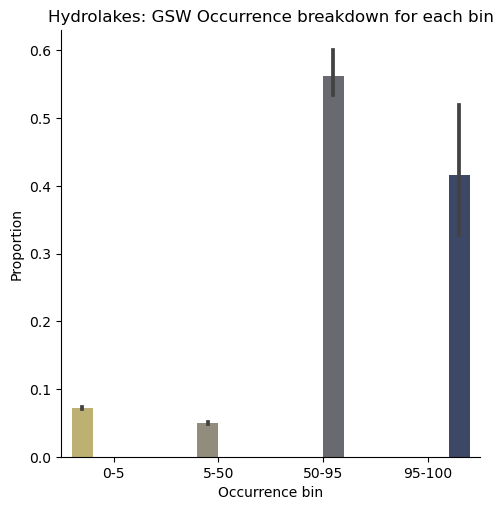

In [45]:
## Reshape (melt) and plot as grouped bar plot (very slow to plot)
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(dfsM, #.iloc[:1000,:],
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('Occurrence bin', 'Proportion') # Weighted percentage of pixels within bin (%)
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

## Add second y-scale
# ax2 = g.ax.twinx()
# ax2.set_yticklabels()

## Stacked bar plot showing lake size

In [65]:
#3 Very Hydrolakes minimum lake size
assert not (np.any(gdf_join_binnedF.Lake_area < 0.1))
assert np.all(gdf_join_binnedF['Area_lt_50'] <= gdf_join_binnedF.Lake_area)

AssertionError: 

In [68]:
## Bin data by lake area
area_bins = pd.IntervalIndex.from_breaks([0.1, 1, 10, 100, 1e3, 1e4, 1e5], closed='left')
area_bins_labels = ['0.1-1', '1-10', '10-100', '100-1000', '1000-10000', '10000-100000']
gdf_join_binnedF['area_bin'] = pd.cut(gdf_join_binnedF.Lake_area, area_bins, right=False, labels=area_bins_labels)
gdf_join_binnedF.head(3)

Hylak_id       0-5      5-50      50-95     95-100  Class_sum  \
0         2  0.092034  0.071082  57.810849  42.026024  30656.007   
1         3  0.232737  0.198573   4.089538  95.479152  26893.426   
2         4  0.122383  0.126409   0.388952  99.362256  24018.110   

                                            geometry  Lake_area  Area_lt_50  \
0  POLYGON ((-119.78782 67.03574, -119.78637 67.0...   30450.64   49.670013   
1  POLYGON ((-109.93976 62.95851, -109.93831 62.9...   26734.29  115.307631   
2  POLYGON ((-98.80636 53.88021, -98.80578 53.880...   23923.04   59.518474   

              area_bin  
0  [10000.0, 100000.0)  
1  [10000.0, 100000.0)  
2  [10000.0, 100000.0)

In [69]:
## Melt for plotting
dfsM2 = gdf_join_binnedF.drop(columns='geometry').melt(id_vars=['Hylak_id', 'area_bin'], var_name='Occurrence bin') # Melted data frame where occurrence categories are MEAN, not SUM

## group for later on
grouped = dfsM2.groupby(['area_bin', 'Occurrence bin']).mean().reset_index()

## view
table = dfsM2.groupby(['area_bin', 'Occurrence bin']).sum() # easier to view than the variable grouped, due to og index
table

Hylak_id         value
area_bin            Occurrence bin                            
[0.1, 1.0)          0-5             691186669999  1.408462e+07
                    5-50            691186669999  9.647613e+06
                    50-95           691186669999  6.829556e+07
                    95-100          691186669999  6.146143e+06
                    Area_lt_50      691186669999  5.833189e+04
                    Class_sum       691186669999  2.696000e+05
                    Lake_area       691186669999  2.683052e+05
[1.0, 10.0)         0-5              10149996717  1.109362e+06
                    5-50             10149996717  6.912346e+05
                    50-95            10149996717  8.206254e+06
                    95-100           10149996717  2.071099e+06
                    Area_lt_50       10149996717  4.104814e+04
                    Class_sum        10149996717  2.980460e+05
                    Lake_area        10149996717  2.963010e+05
[10.0, 100.0)       0-5                 59835371  5.131865e+04
                    5-50                59835371  3.464153e+04
                    50-95               59835371  4.872178e+05
                    95-100              59835371  3.014176e+05
                    Area_lt_50          59835371  1.930616e+04
                    Class_sum           59835371  2.113562e+05
                    Lake_area           59835371  2.101669e+05
[100.0, 1000.0)     0-5                   411254  2.509282e+03
                    5-50                  411254  2.171049e+03
                    50-95                 411254  2.939128e+04
                    95-100                411254  3.422835e+04
                    Area_lt_50            411254  1.068469e+04
                    Class_sum             411254  1.721728e+05
                    Lake_area             411254  1.712227e+05
[1000.0, 10000.0)   0-5                     3383  9.945739e+01
                    5-50                    3383  8.168740e+01
                    50-95                   3383  1.608585e+03
                    95-100                  3383  3.910270e+03
                    Area_lt_50              3383  4.252160e+03
                    Class_sum               3383  1.399644e+05
                    Lake_area               3383  1.392286e+05
[10000.0, 100000.0) 0-5                       30  1.178959e+00
                    5-50                      30  7.365955e-01
                    50-95                     30  6.528013e+01
                    95-100                    30  4.328043e+02
                    Area_lt_50                30  4.543076e+02
                    Class_sum                 30  1.312134e+05
                    Lake_area                 30  1.305198e+05

In [70]:
## Save this table
table.to_csv(os.path.join(table_dir, 'breakdown-size-oc.csv'))

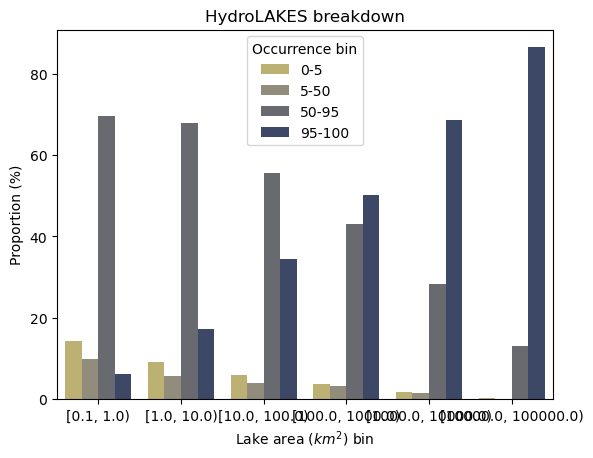

In [36]:
## Plot lakes by double breakdown

## plot colors
plot_colors = ['r','g','b','orange']

## Try stacked bar plots... problem is that I can't add averages, and I can't easily divide dataframes with sum columns and also categorical columns...
# bar3 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[3]) # .query("`Occurrence bin` == '0-5'" #"@np.isin(`Occurrence bin`, ['0-5', '5-50'])"
# bar2 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['50-95','5-50', '0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[2])
# bar1 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['5-50', '0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[1])
# bar0 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[0])

## Try again (I verified each group sums to 1), can also use barplot or catplot(..., kind='bar')
bar0 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])], x="area_bin",  y="value", hue='Occurrence bin', errorbar=('ci', 95), color=plot_colors[0], palette='cividis_r')
# bar0.set_axis_labels('Proportion (%)', 'Area ($km^2$) bin')
bar0.axes.set_xlabel('Lake area ($km^2$) bin')
bar0.axes.set_ylabel('Proportion (%)')
bar0.axes.set_title('HydroLAKES breakdown')
plt.show()

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/_collections_abc.py:994: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/_collections_abc.py:994: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


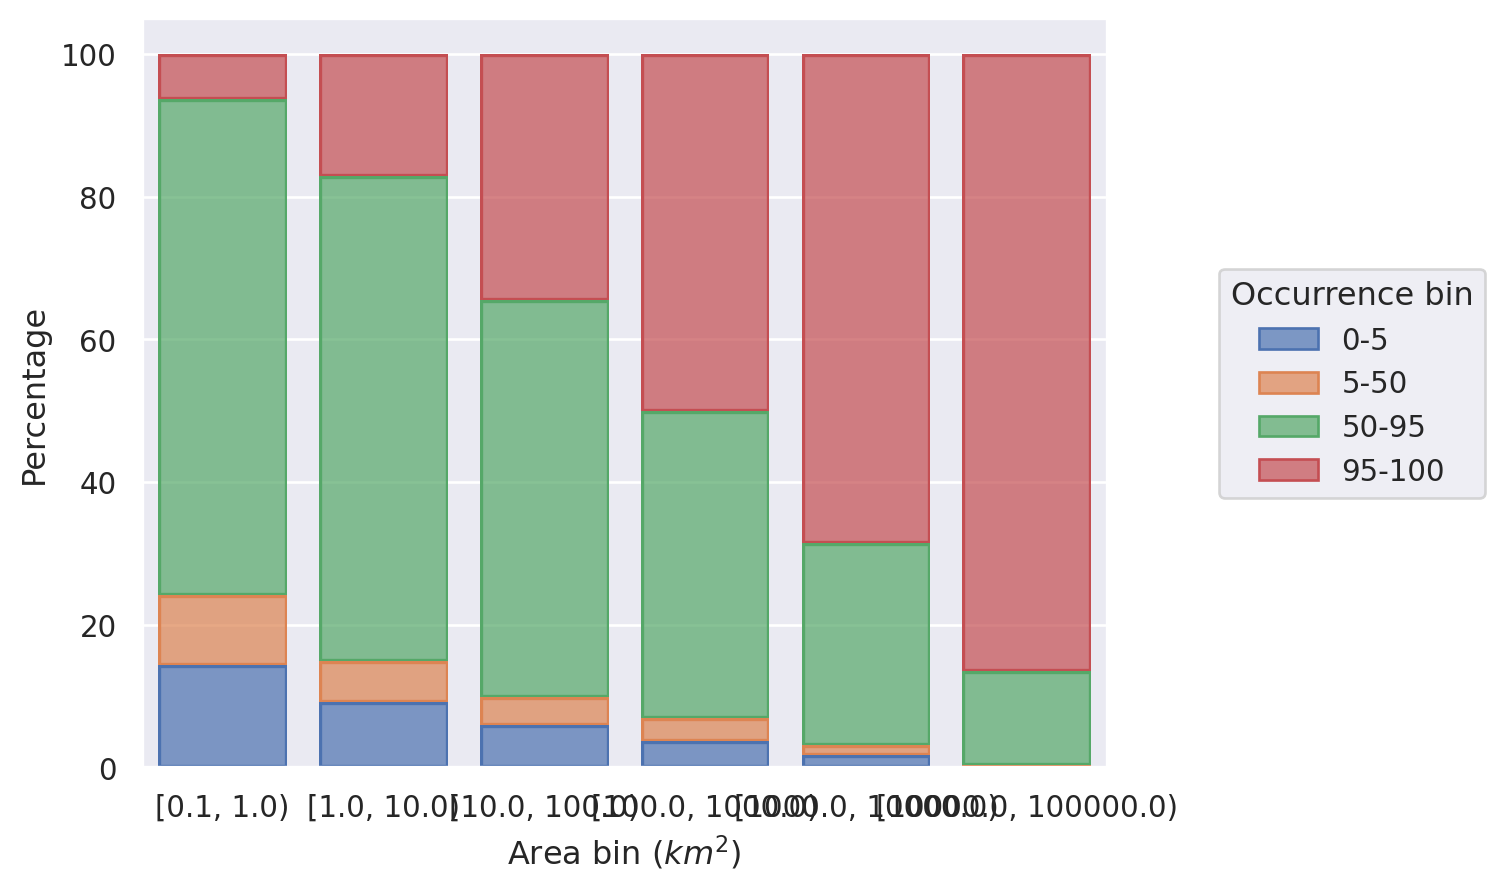

In [37]:
## Actual stacked plot using new sns objects API.
from seaborn import objects as so
sns.set_palette('cividis_r') # doesn't st color map... not sure why...
g = so.Plot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])],
    x="area_bin",  y="value",  color='Occurrence bin').add(so.Bar(), so.Agg(), so.Stack())
# g. ax.set_xlabels(bin_labels)
g.label(x='Area bin ($km^2$)', y='Percentage')
# g.show()

## Scrap

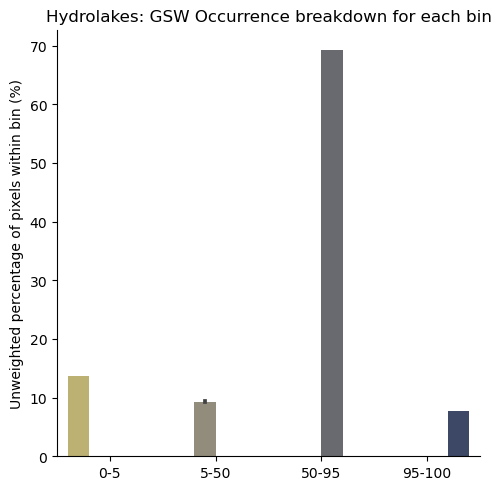

In [ ]:
## Plot
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(gdf_join_binned[['Hylak_id']+bin_labels].melt(id_vars='Hylak_id', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('', 'Unweighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

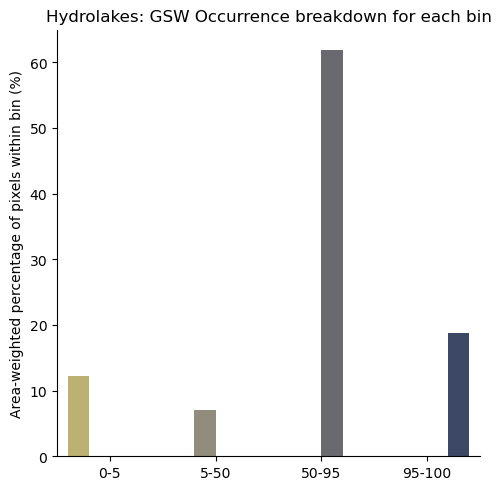

In [ ]:
## Weighted average histogram/barplot without conf intervals
dfWA = pd.DataFrame([weightAvg, bin_labels], index=['value','bin']).T
g = sns.catplot(dfWA, hue = 'bin', y='value', x='bin', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Area-weighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

Text(0, 0.5, 'Unweighted percentage of pixels within bin (%)')

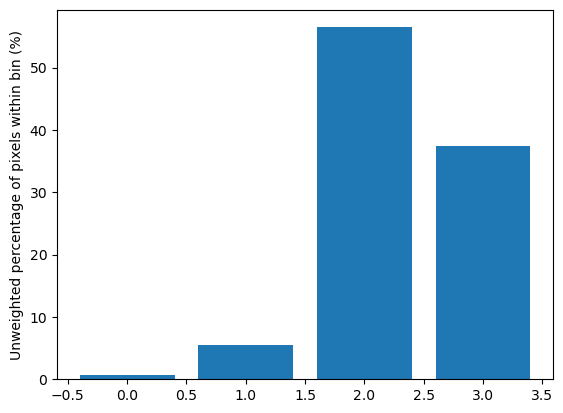

In [ ]:
## Weighted average histogram/barplot (alternate using MPL)

plt.bar(x=np.arange(4), height=weightAvg)
plt.ylabel( 'Unweighted percentage of pixels within bin (%)')


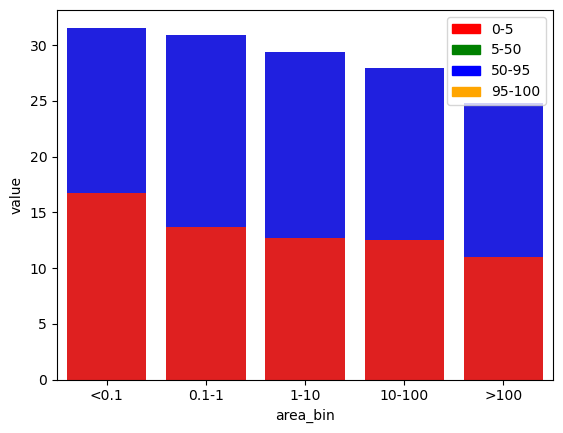

In [ ]:
## Now plot as stacked bar plot (from https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot)
import matplotlib.patches as mpatches

# set plot style: grey grid in the background:
# sns.set(style="darkgrid")

# set the figure size
# plt.figure(figsize=(14, 14))

## plot colors
plot_colors = ['r','g','b','orange']

## small dataset for testing
dfsM2_sub = dfsM2 #.iloc[1::80,:]

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = dfsM2_sub.groupby('area_bin')['value'].mean().reset_index()

# bar chart 1 -> top bars (group of 'smoker=No')
# bar_total = sns.barplot(x="area_bin",  y="value", data=total, color=plot_colors[0])
bar_total = dfsM2_sub[np.isin(dfsM2_sub['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])]

# bottom bar ->  take only smoker=Yes values from the data
bin1 = dfsM2_sub[dfsM2_sub['Occurrence bin']=='0-5']
bin2 = dfsM2_sub[np.isin(dfsM2_sub['Occurrence bin'], ['5-50', '0-5'])]
bin3 = dfsM2_sub[np.isin(dfsM2_sub['Occurrence bin'], ['50-95','5-50', '0-5'])]
# bin4 = dfsM2_sub[dfsM2_sub['Occurrence bin']=='95-100'] # not needed

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
# bar2 = sns.barplot(x="area_bin", y="value", data=bin1, estimator='mean', errorbar=None,  color=plot_colors[1])
# bar3 = sns.barplot(x="area_bin", y="value", data=bin2, estimator='mean', errorbar=None,  color=plot_colors[2])
# bar4 = sns.barplot(x="area_bin", y="value", data=bin3, estimator='mean', errorbar=None,  color=plot_colors[3])

# simple way of computing remaining bars by addition
total_bin1 = bin1.groupby('area_bin')['value'].mean().reset_index()
total_bin2 = bin2.groupby('area_bin')['value'].mean().reset_index()
total_bin3 = bin3.groupby('area_bin')['value'].mean().reset_index()

# add bar plots for sub totals
bar3 = sns.barplot(x="area_bin",  y="value", data=total_bin3, color=plot_colors[2])
bar2 = sns.barplot(x="area_bin",  y="value", data=total_bin2, color=plot_colors[1])
bar1 = sns.barplot(x="area_bin",  y="value", data=total_bin1, color=plot_colors[0])

# add legend
bars = [mpatches.Patch(color=j, label=bin_labels[i]) for i, j in enumerate(plot_colors)]
# top_bar = mpatches.Patch(color='darkblue', label=bin_labels[0])
# bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
plt.legend(handles=bars)

# show the graph
plt.show()

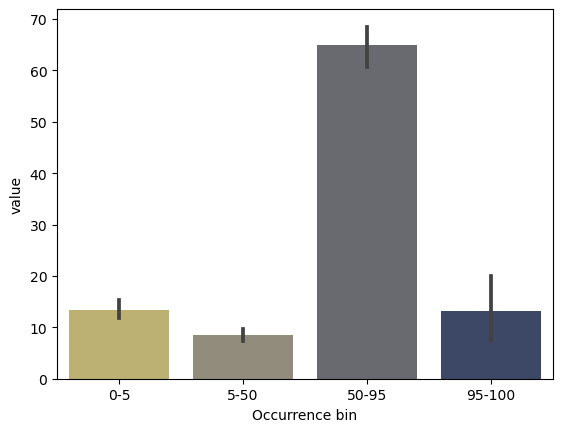

In [ ]:
## Now dubplicate unweighted mean
bar0 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])], x="Occurrence bin",  y="value", errorbar=('ci', 95), color=plot_colors[0], palette='cividis_r')

## Scrap functions

In [ ]:
def getRequests():
    """Generates a list of work items to be downloaded. Should be dquivalent to 'return modN', where modN is mod number.
    """    
    ## Load vector dataset
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectv = vect.filter("Pour_lat > 59.5").filter("Pour_lat < 59.6") #.filter("Long == -126.25")

    ## Aggregate by Hylak_id mod
    # return np.unique(vectF.aggregate_array('Country').getInfo()) # change to vect not vectF for real run
    return np.unique(vect.aggregate_array(modstr).getInfo()) # change to vect not vectF for real run

In [ ]:
def getRequests():
    ''' shortcut function that doesn't take 2.5 minutes.'''
    return range(modN)

In [ ]:
def addMod(feature):
    '''Adds a new mod[n] column to FeatureCollection'''
    mod = modN # defined at beginning
    modComputed = ee.Number(feature.get('Hylak_id')).mod(mod) # ee.Number.parse(
    return feature.set('mod'+str(mod), modComputed) # .double()

## ERRORS

```python
Computing (Hi Ethan!)... 
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
HttpError                                 Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py:328, in _execute_cloud_call(call, num_retries)
    327 try:
--> 328   return call.execute(num_retries=num_retries)
    329 except googleapiclient.errors.HttpError as e:

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py:130, in positional.<locals>.positional_decorator.<locals>.positional_wrapper(*args, **kwargs)
    129         logger.warning(message)
--> 130 return wrapped(*args, **kwargs)

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py:938, in HttpRequest.execute(self, http, num_retries)
    937 if resp.status >= 300:
--> 938     raise HttpError(resp, content, uri=self.uri)
    939 return self.postproc(resp, content)

HttpError: <HttpError 400 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "User memory limit exceeded.". Details: "User memory limit exceeded.">

During handling of the above exception, another exception occurred:

EEException                               Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py:6961, in zonal_stats_by_group(in_value_raster, in_zone_vector, out_file_path, statistics_type, decimal_places, denominator, scale, crs, tile_scale, return_fc, verbose, timeout, proxies, **kwargs)
   6960     else:
-> 6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
...
   6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
-> 6964     raise Exception(e)

Exception: User memory limit exceeded.

```python
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 429 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.". Details: "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 73, in retry_decorator
    return __retry_internal(partial(f, *args, **kwargs), exceptions, tries, delay, max_delay, backoff, jitter,
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 33, in __retry_internal
...
    772     return self._value
    773 else:
--> 774     raise self._value

EEException: Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.

Some error about element has a missing property. I treated it like an error caused by returning an empty table/feature collection and it seemed to resolve it.

This happened after 7 hrs of running (with 22,065 files generated)
```python
Downloading data from https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/tables/356e1d94dc202d39f9c68cc224730aa3-c7c5ab24b3d58dd6aa199d1a90b902e0:getFeatures
Please wait ...
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v2/tiles/HL_zStats_Oc_Long-159.75_Lat55.75.csv
Done with group:  [-159.75   55.75]
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 503 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "The service is currently unavailable.". Details: "The service is currently unavailable.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py", line 6962, in zonal_stats_by_group
    ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py", line 1523, in ee_export_vector
    selectors = ee_object.first().propertyNames().getInfo()
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/computedobject.py", line 98, in getInfo
    return data.computeValue(self)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 764, in computeValue
    return _execute_cloud_call(
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 330, in _execute_cloud_call
...
   6962         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6964 except Exception as e:
-> 6965     raise Exception(e)

Exception: The service is currently unavailable.